In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')


In [2]:
train_dir = "./Train"
test_dir = "./Test"
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR =  0.00003
# Subset of classes for reduced dataset
subset_classes = ['Abuse', 'Vandalism', 'Shooting', 'Arson', 'RoadAccidents','Assault','Explosion','NormalVideos']
CLASS_LABELS = subset_classes
#CLASS_LABELS = subset_classes#['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   preprocessing_function=preprocess_fun)

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun)

In [4]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    classes=subset_classes,
                                                    seed=SEED)

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  classes=subset_classes,
                                                  seed=SEED)

Found 1064630 images belonging to 8 classes.
Found 88613 images belonging to 8 classes.


In [5]:
# Visualizing the class distribution
train_class_counts = [list(train_generator.classes).count(i) for i in range(len(CLASS_LABELS))]
test_class_counts = [list(test_generator.classes).count(i) for i in range(len(CLASS_LABELS))]


In [6]:
# Train data distribution
fig = px.bar(x=CLASS_LABELS, y=train_class_counts, color=CLASS_LABELS, color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title="Number of Images")
fig.update_layout(showlegend=True,
                  title={'text': 'Train Data Distribution',
                         'y': 0.95,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [7]:
# Test data distribution
fig = px.bar(x=CLASS_LABELS, y=test_class_counts, color=CLASS_LABELS, color_continuous_scale="Emrld")
fig.update_xaxes(title="Classes")
fig.update_yaxes(title="Number of Images")
fig.update_layout(showlegend=True,
                  title={'text': 'Test Data Distribution',
                         'y': 0.95,
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'})
fig.show()

In [8]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                          include_top=False,
                                                          weights="imagenet")(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(len(subset_classes), activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    densenet_feature_extractor = feature_extractor(inputs)
    classification_output = classifier(densenet_feature_extractor)
    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(LR),
                  loss='categorical_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])
    return model

model = define_compile_model()
clear_output()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,091,976 (30.87 MB)

 Trainable params: 8,008,328 (30.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
history = model.fit(x=train_generator, validation_data=test_generator, epochs=EPOCHS)


16635/16635 ━━━━━━━━━━━━━━━━━━━━ 47746s 3s/step - auc: 0.9333 - loss: 0.8066 - val_auc: 0.9006 - val_loss: 1.1392


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 353s 253ms/step
ROC AUC score: 0.8474200012574742


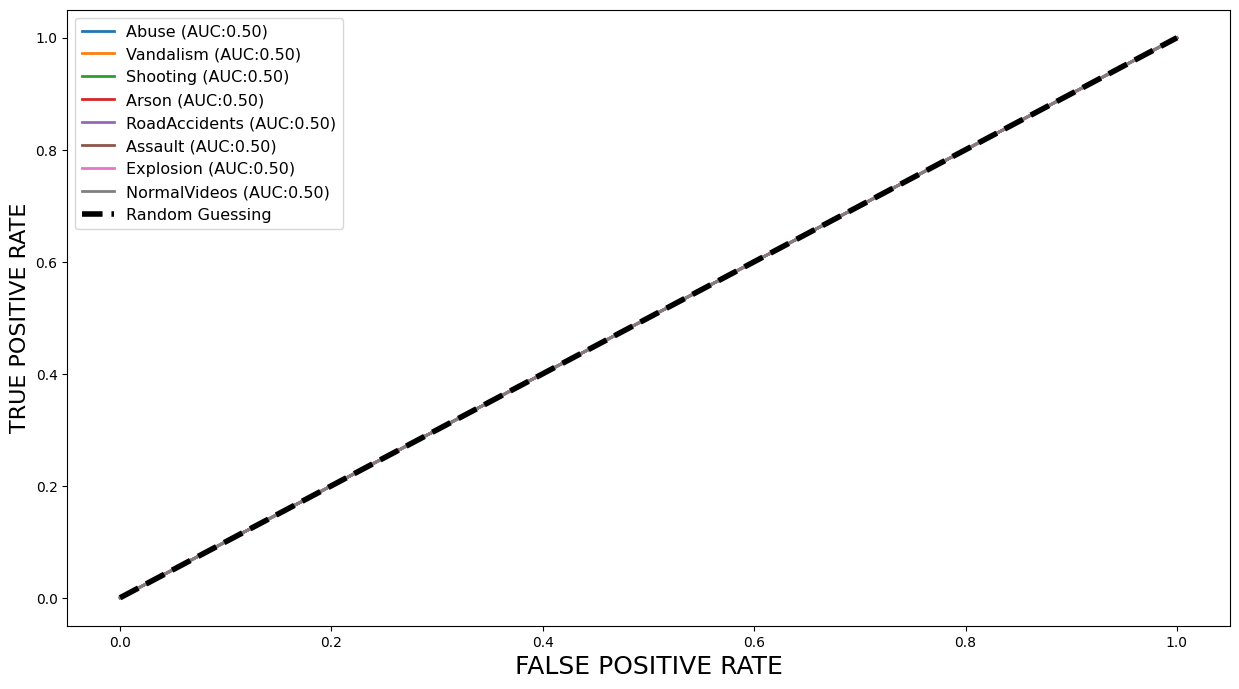

In [10]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)

    # Ensure y_pred is in the same binarized format
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(CLASS_LABELS):
        if idx >= y_test.shape[1] or idx >= y_pred.shape[1]:
            print(f"Index {idx} is out of bounds for y_test or y_pred with shape {y_test.shape}, {y_pred.shape}")
            continue
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
    
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()


In [12]:
from keras.models import load_model

# Save your model
model.save('densenet121_ucfcrime.keras')


In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Load the previously trained model
loaded_model = load_model('densenet121_ucfcrime.keras')

# Recompile the model
loaded_model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "./Train"
test_dir = "./Test"
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 1
LR = 0.00003
subset_classes = ['Abuse', 'Vandalism', 'Shooting', 'Arson', 'RoadAccidents', 'Assault', 'Explosion', 'NormalVideos']
CLASS_LABELS = subset_classes

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes=subset_classes,
    class_mode='categorical',  # Use categorical for multi-class classification
    shuffle=True,
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    classes=subset_classes,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)


Found 1064630 images belonging to 8 classes.
Found 88613 images belonging to 8 classes.


Found 111308 images belonging to 14 classes.
class_labels: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


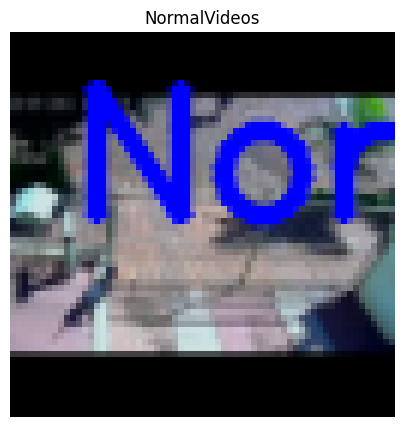

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


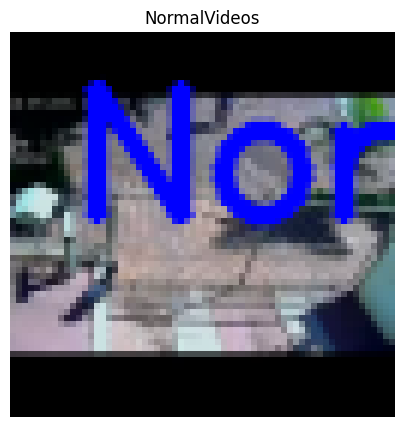

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


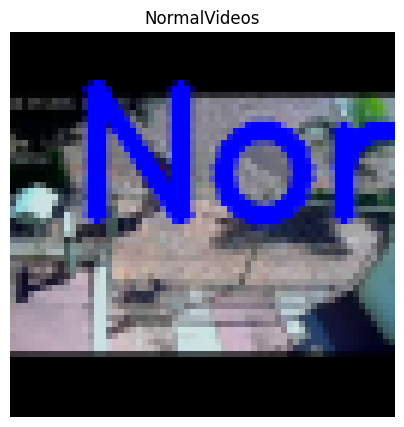

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


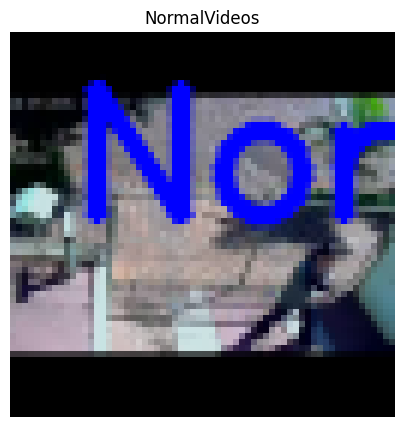

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


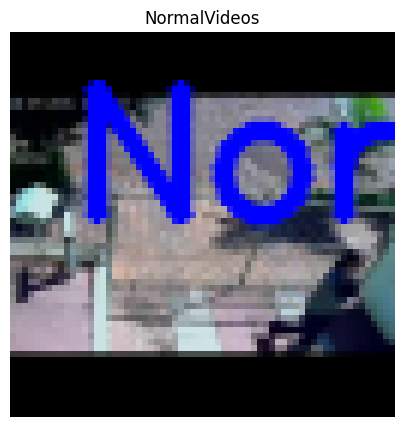

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


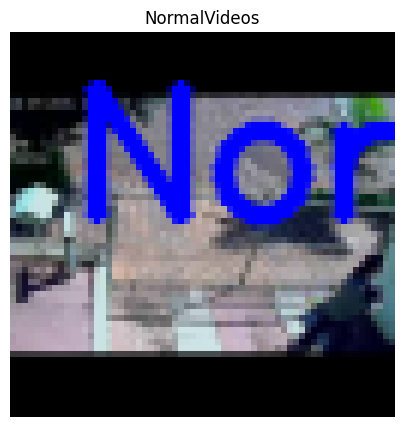

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


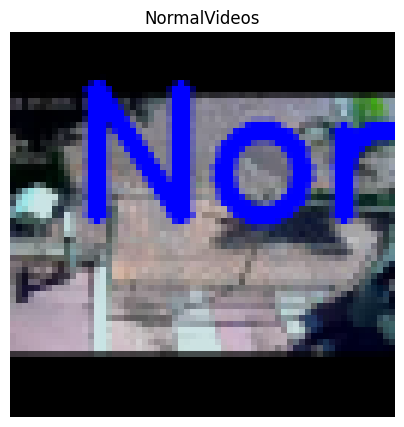

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


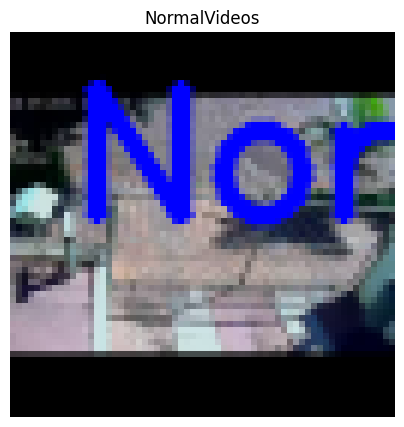

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


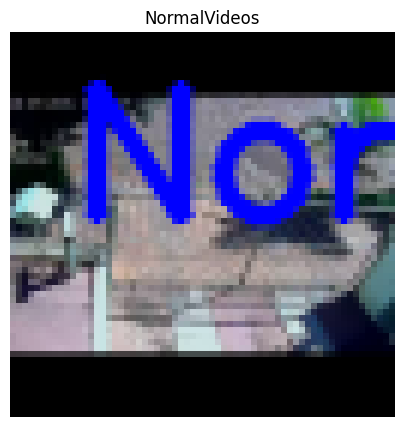

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7


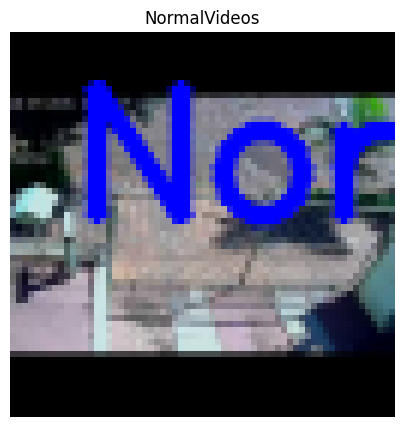

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(pred): 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
pred: [[0. 0. 0. 0. 0. 0. 0. 1.]]
np.argmax(p

KeyboardInterrupt: 

In [19]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

# Load the previously trained model
loaded_model = load_model('densenet121_ucfcrime.keras')

# Prepare test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './test',
    target_size=(64, 64),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Define a function to annotate images
def annotate_images(generator, model, output_dir='annotated_images'):
    os.makedirs(output_dir, exist_ok=True)
    class_labels = list(generator.class_indices.keys())
    
    print(f"class_labels: {class_labels}")  # Debug: Print class labels

    for i in range(len(generator.filenames)):
        img, _ = next(generator)
        pred = model.predict(img)
        
        print(f"pred: {pred}")  # Debug: Print prediction values
        print(f"np.argmax(pred): {np.argmax(pred)}")  # Debug: Print the index of the highest prediction
        
        # Ensure the index is within the valid range
        if np.argmax(pred) >= len(class_labels):
            print(f"Index {np.argmax(pred)} out of range for class_labels.")
            continue
        
        label = class_labels[np.argmax(pred)]

        # Load the original image
        img_path = os.path.join(generator.directory, generator.filenames[i])
        original_img = cv2.imread(img_path)

        # Annotate the image
        annotated_img = cv2.putText(original_img, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

        # Save the annotated image
        output_path = os.path.join(output_dir, os.path.basename(generator.filenames[i]))
        cv2.imwrite(output_path, annotated_img)
        
        if i < 10:  # Display the first 10 images for demonstration
            plt.figure(figsize=(5, 5))
            plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
            plt.title(label)
            plt.axis('off')
            plt.show()

# Run the annotation function
annotate_images(test_generator, loaded_model)
